C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Loss: 0.6190
Epoch 2/20, Loss: 0.2987
Epoch 3/20, Loss: 0.1441
Epoch 4/20, Loss: 0.1466
Epoch 5/20, Loss: 0.1152
Epoch 6/20, Loss: 0.0782
Epoch 7/20, Loss: 0.0701
Epoch 8/20, Loss: 0.0663
Epoch 9/20, Loss: 0.0520
Epoch 10/20, Loss: 0.0462
Epoch 11/20, Loss: 0.0436
Epoch 12/20, Loss: 0.0397
Epoch 13/20, Loss: 0.0365
Epoch 14/20, Loss: 0.0352
Epoch 15/20, Loss: 0.0339
Epoch 16/20, Loss: 0.0353
Epoch 17/20, Loss: 0.0327
Epoch 18/20, Loss: 0.0315
Epoch 19/20, Loss: 0.0385
Epoch 20/20, Loss: 0.0443
Classification Report:
              precision    recall  f1-score   support

  Non-Lesion       0.99      0.98      0.99   8879085
      Lesion       0.97      0.98      0.97   4228115

    accuracy                           0.98  13107200
   macro avg       0.98      0.98      0.98  13107200
weighted avg       0.98      0.98      0.98  13107200



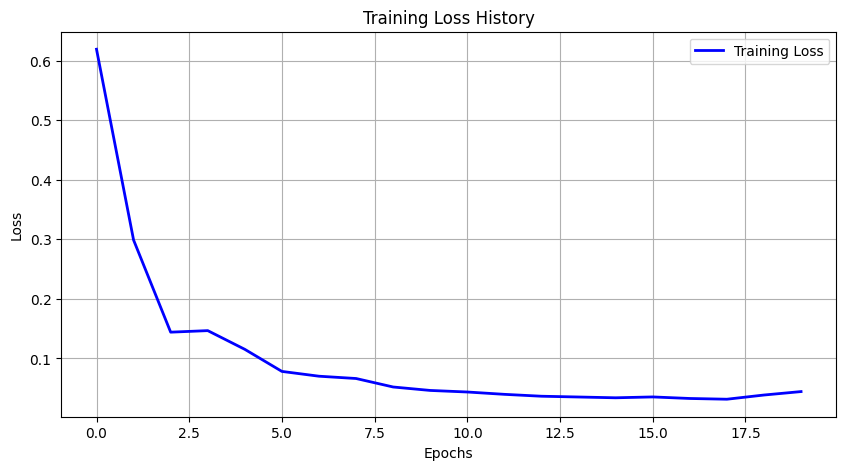

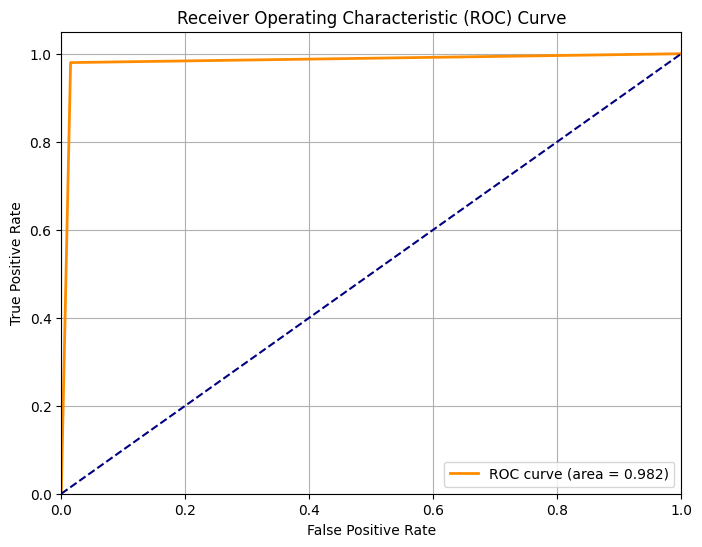

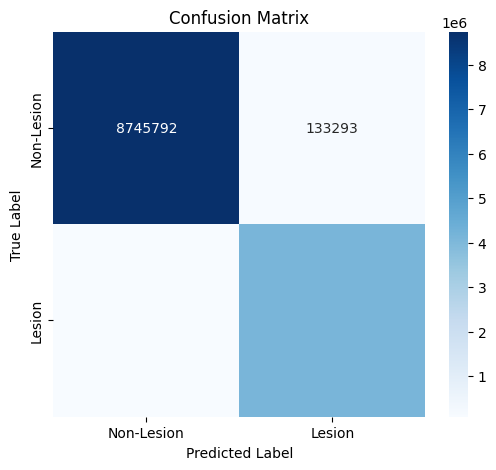

In [1]:
# FAT-Net_ ph2_dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, roc_curve, auc, confusion_matrix, classification_report
from torchvision import models as resnet_model

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report



# Custom Dataset for Skin Lesion Segmentation
class SkinLesionDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_size)
        img = img / 255.0  # Normalize
        img = np.transpose(img, (2, 0, 1))  # Convert to (C, H, W)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.img_size)
        mask = mask / 255.0  # Normalize to [0,1]
        mask = np.expand_dims(mask, axis=0)  # Add channel dimension
        
        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

# Load Dataset
train_dataset = SkinLesionDataset('ph2_dataset/trainx/', 'ph2_dataset/trainy/')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Define FAT-Net Model
class FAT_Net(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(FAT_Net, self).__init__()
        
        resnet = resnet_model.resnet34(pretrained=True)

        self.firstconv = resnet.conv1
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        self.decoder4 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1)
        self.decoder3 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1)
        self.decoder2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.decoder1 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        
        self.final_conv = nn.Conv2d(32, n_classes, kernel_size=1)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        e0 = self.firstconv(x)
        e0 = self.firstbn(e0)
        e0 = self.firstrelu(e0)

        e1 = self.encoder1(e0)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
        
        out = self.final_conv(d1)
        out = self.activation(out)
        return out

# Initialize Model
model = FAT_Net()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
num_epochs = 20
loss_history = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    loss_history.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Save Model
torch.save(model.state_dict(), 'skin_lesion_fatnet.pth')

# Generate Classification Report
y_true, y_pred = [], []
with torch.no_grad():
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float()
        
        y_true.extend((masks.cpu().numpy() > 0.5).astype(int).flatten())  # Threshold masks to binary
        y_pred.extend(preds.cpu().numpy().flatten()) 

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Non-Lesion', 'Lesion']))

# Plot Training Loss History
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss', color='blue', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.grid(True)
plt.show()

# Compute ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Lesion', 'Lesion'], yticklabels=['Non-Lesion', 'Lesion'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# FAT-Net_ ph2_dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, roc_curve, auc, confusion_matrix, classification_report
from torchvision import models as resnet_model

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report



# Custom Dataset for Skin Lesion Segmentation
class SkinLesionDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_size)
        img = img / 255.0  # Normalize
        img = np.transpose(img, (2, 0, 1))  # Convert to (C, H, W)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.img_size)
        mask = mask / 255.0  # Normalize to [0,1]
        mask = np.expand_dims(mask, axis=0)  # Add channel dimension
        
        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

# Load Dataset
train_dataset = SkinLesionDataset('isic2018/trainx/', 'isic2018/trainy/')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Define FAT-Net Model
class FAT_Net(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(FAT_Net, self).__init__()
        
        resnet = resnet_model.resnet34(pretrained=True)

        self.firstconv = resnet.conv1
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        self.decoder4 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1)
        self.decoder3 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1)
        self.decoder2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.decoder1 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        
        self.final_conv = nn.Conv2d(32, n_classes, kernel_size=1)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        e0 = self.firstconv(x)
        e0 = self.firstbn(e0)
        e0 = self.firstrelu(e0)

        e1 = self.encoder1(e0)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
        
        out = self.final_conv(d1)
        out = self.activation(out)
        return out

# Initialize Model
model = FAT_Net()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
num_epochs = 20
loss_history = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    loss_history.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Save Model
torch.save(model.state_dict(), 'skin_lesion_fatnet.pth')

# Generate Classification Report
y_true, y_pred = [], []
with torch.no_grad():
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float()
        
        y_true.extend((masks.cpu().numpy() > 0.5).astype(int).flatten())  # Threshold masks to binary
        y_pred.extend(preds.cpu().numpy().flatten()) 

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Non-Lesion', 'Lesion']))

# Plot Training Loss History
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss', color='blue', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.grid(True)
plt.show()

# Compute ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Lesion', 'Lesion'], yticklabels=['Non-Lesion', 'Lesion'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
